# Sales Forecasting - Baseline Model (Alpha)

**Goal:** To build a baseline machine learning model to forecast grocery sales using historical data.

**Approach:** This notebook uses `Polars` for efficient data handling and a `LightGBM` model with a standard set of features and parameters. The performance of this model will serve as our baseline.

**Result:** The final model, loaded from `model_alpha.txt`, achieved a validation RMSE of **19.01**.

## 1. Data Loading and Preparation

In [1]:
from sklearn.metrics import mean_squared_error
from datasets import load_dataset
import polars as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


/Users/dhruvpatel/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("dunnowho/grocery-sales-forecasting")

In [3]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'],
        num_rows: 125497040
    })
    test: Dataset({
        features: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'],
        num_rows: 3370464
    })
})


In [4]:
ds['train'].to_pandas().head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [5]:
ds['test'].to_pandas().head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,125497040,2017-08-16,1,96995,NaN,0.0
1,125497041,2017-08-16,1,99197,NaN,0.0
2,125497042,2017-08-16,1,103501,NaN,0.0
3,125497043,2017-08-16,1,103520,NaN,0.0
4,125497044,2017-08-16,1,103665,NaN,0.0


In [6]:
# Convert the Hugging Face Dataset to Polars DataFrame
# This is a very fast and memory-efficient operation.
train_df = ds['train'].to_polars()
test_df = ds['test'].to_polars()

In [8]:
train_df.head()

id,date,store_nbr,item_nbr,unit_sales,onpromotion
i64,str,i64,i64,f64,f64
0,"""2013-01-01""",25,103665,7.0,null
1,"""2013-01-01""",25,105574,1.0,null
2,"""2013-01-01""",25,105575,2.0,null
3,"""2013-01-01""",25,108079,1.0,null
4,"""2013-01-01""",25,108701,1.0,null


In [9]:
train_df.shape

(125497040, 6)

In [10]:
print(train_df['item_nbr'].unique())

shape: (4_036,)
Series: 'item_nbr' [i64]
[
	96995
	99197
	103501
	103520
	103665
	…
	2123863
	2124052
	2126842
	2126944
	2127114
]


In [11]:
print(train_df['item_nbr'].unique().shape)

(4036,)


In [12]:
print(train_df['id'].unique().shape)

(125497040,)


In [13]:
test_df.tail()

id,date,store_nbr,item_nbr,unit_sales,onpromotion
i64,str,i64,i64,f64,f64
128867499,"""2017-08-31""",54,2132163,null,0.0
128867500,"""2017-08-31""",54,2132318,null,0.0
128867501,"""2017-08-31""",54,2132945,null,0.0
128867502,"""2017-08-31""",54,2132957,null,0.0
128867503,"""2017-08-31""",54,2134244,null,0.0


In [14]:
test_df.shape

(3370464, 6)

In [15]:
print(test_df['item_nbr'].unique().shape)

(3901,)


In [16]:
# Define the date where you want to split your training data
validation_start_date = "2017-08-01"

# Create the training and validation sets from your main train_df
X_train = train_df.filter(pl.col("date") < validation_start_date)
X_val = train_df.filter(pl.col("date") >= validation_start_date)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Validation set shape: {test_df.shape}")

Training set shape: (123926072, 6)
Validation set shape: (1570968, 6)
Validation set shape: (3370464, 6)


## 2. Feature Engineering

In [17]:
# Rename for clarity before we create the final X/y sets
train_set = X_train
val_set = X_val

def feature_engineer(df):
    return df.with_columns([
        pl.col('date').str.to_date('%Y-%m-%d'),
        pl.col('onpromotion').fill_null(False).cast(pl.Boolean)
    ]).with_columns([
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.month().alias('month'),
        pl.col('date').dt.weekday().alias('day_of_week'),
        pl.col('date').dt.week().alias('week_of_year')
    ])

# Apply the function to all data splits
train_set = feature_engineer(train_set)
val_set = feature_engineer(val_set)
test_df = feature_engineer(test_df)

print("Feature engineering complete.")
print("Training set columns:", train_set.columns)

Feature engineering complete.
Training set columns: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year', 'month', 'day_of_week', 'week_of_year']


## 3. Exploratory Data Analysis (EDA)

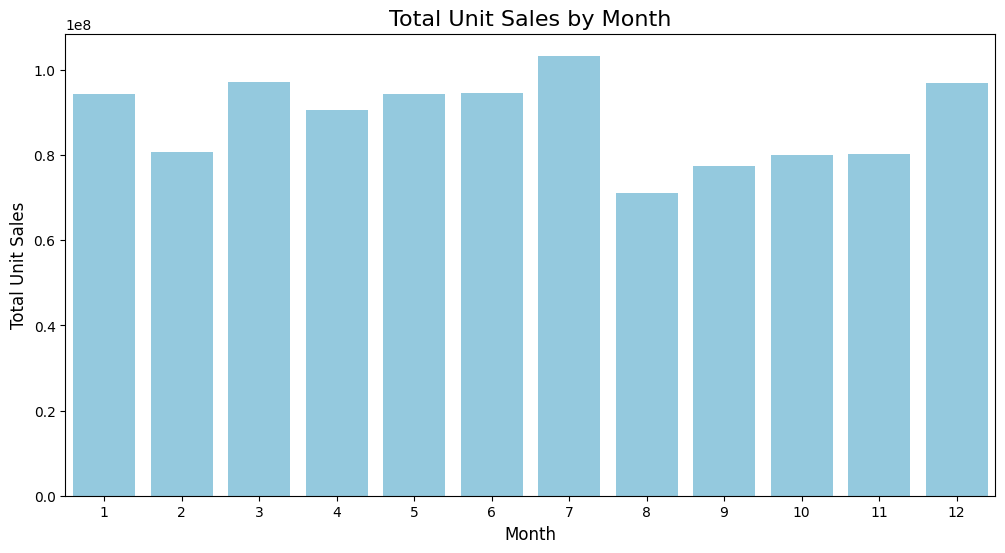

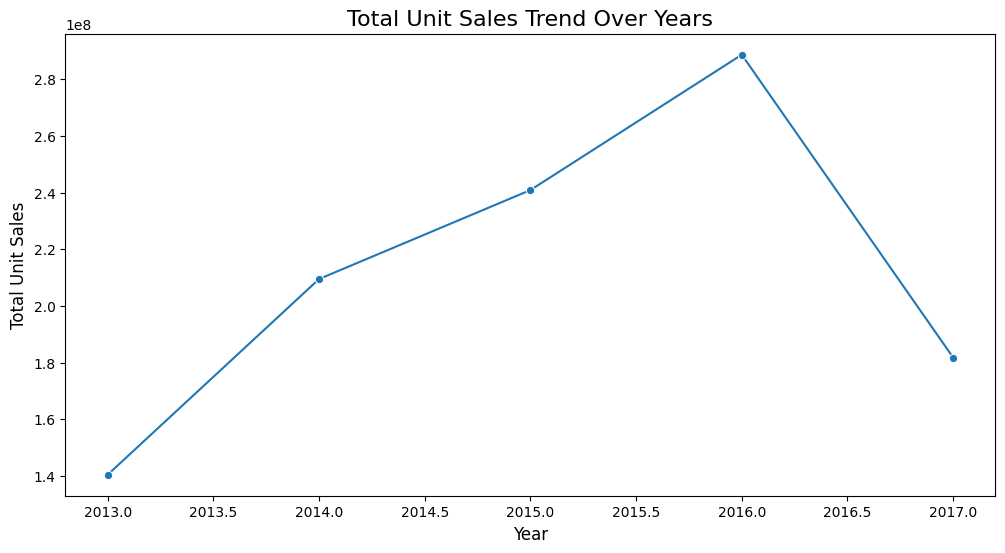

In [18]:
# --- EDA Plots ---

# a. Monthly Sales Trends
# This helps to see the seasonal pattern within a year
monthly_sales = (
    train_set.group_by("month")
    .agg(pl.sum("unit_sales"))
    .sort("month")
)

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales.to_pandas(), x="month", y="unit_sales", color="skyblue")
plt.title("Total Unit Sales by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Unit Sales", fontsize=12)
plt.show()


# b. Yearly Sales Trends
# This shows the overall growth or decline over the years
yearly_sales = (
    train_set.group_by("year")
    .agg(pl.sum("unit_sales"))
    .sort("year")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sales.to_pandas(), x="year", y="unit_sales", marker='o')
plt.title("Total Unit Sales Trend Over Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Unit Sales", fontsize=12)
plt.show()

In [17]:
# Define feature columns and the target column
features = ['store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day_of_week', 'week_of_year']
target = 'unit_sales'
categorical_features = ['store_nbr', 'item_nbr', 'onpromotion']

# Create final training, validation, and test sets
X_train = train_set[features]
y_train = train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_df[features]

print("X/y splits created.")

X/y splits created.


## 4. Model Training


# Create LightGBM datasets (requires converting to pandas)
train_data = lgb.Dataset(X_train.to_pandas(), label=y_train.to_pandas(), categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val.to_pandas(), label=y_val.to_pandas(), categorical_feature=categorical_features)

# Define model parameters
params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

# Train the model
print("Training LightGBM model...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(100, verbose=True)]
)
print("Model training complete.")

# Save the model to a file
model.save_model('model_alpha.txt')

print("Model saved successfully!")

## 5. Loading the Pre-Trained Baseline Model

In [18]:
# Load the model from the file
model = lgb.Booster(model_file='model_alpha.txt')

print("Model loaded successfully!")

Model loaded successfully!


## 6. Model Evaluation and Visualization

In [19]:
# Make predictions on the validation set
val_predictions = model.predict(X_val.to_pandas(), num_iteration=model.best_iteration)

# Calculate the Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_val.to_pandas(), val_predictions, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 19.010366225613225


In [20]:
# Make predictions on the final test set
test_predictions = model.predict(X_test.to_pandas(), num_iteration=model.best_iteration)

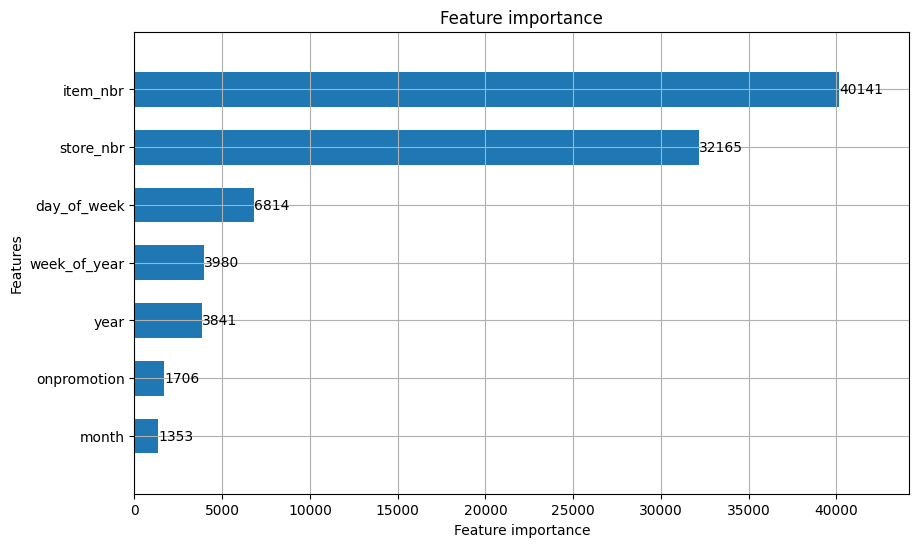

In [21]:

lgb.plot_importance(model, height=0.6, figsize=(10, 6))
plt.show()

In [22]:
# Add predictions to the validation set dataframe
val_set_with_preds = val_set.with_columns(
    pl.Series(name="predicted_sales", values=val_predictions)
)

# Choose a specific store and item to visualize
# Let's pick an item from a store that has consistent sales
store_to_plot = 44
item_to_plot = 105574 # A common grocery item

# Filter for that specific time series
single_item_df = val_set_with_preds.filter(
    (pl.col("store_nbr") == store_to_plot) & (pl.col("item_nbr") == item_to_plot)
)

# Convert to pandas for easy plotting
single_item_df_pd = single_item_df.to_pandas()

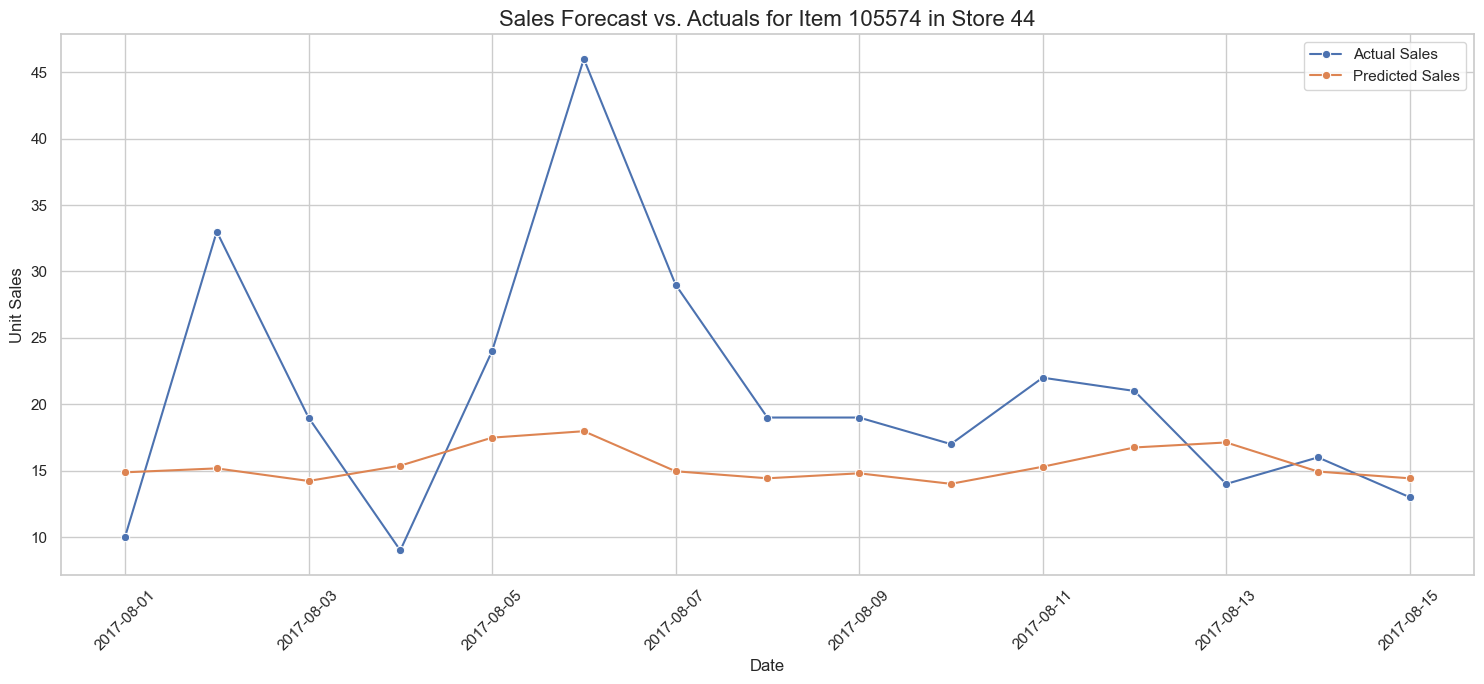

In [23]:

# Set plot style and size
sns.set(style='whitegrid')
plt.figure(figsize=(15, 7))

# Plot actual vs. predicted sales
sns.lineplot(data=single_item_df_pd, x='date', y='unit_sales', label='Actual Sales', marker='o')
sns.lineplot(data=single_item_df_pd, x='date', y='predicted_sales', label='Predicted Sales', marker='o')

# Add titles and labels
plt.title(f'Sales Forecast vs. Actuals for Item {item_to_plot} in Store {store_to_plot}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
# --- Create a Detailed Prediction File ---

# Add the predictions as a new column to the original test_df
# This keeps all the original feature information
predictions_with_features = test_df.with_columns(
    pl.Series(name="predicted_sales", values=test_predictions)
)

# Clip at 0, since we can't have negative sales
predictions_with_features = predictions_with_features.with_columns(
    pl.when(pl.col("predicted_sales") < 0)
    .then(0)
    .otherwise(pl.col("predicted_sales"))
    .alias("predicted_sales")
)

# Select the columns you want in your final CSV
# This includes the id, original features, and your new prediction
final_predictions_df = predictions_with_features[
    ['id', 'date', 'store_nbr', 'item_nbr', 'onpromotion', 'predicted_sales']
]

# Save the detailed submission file
final_predictions_df.write_csv("detailed_predictions_alpha.csv")

print("Detailed prediction file 'detailed_predictions_alpha.csv' created successfully!")
print("Prediction file head:")
print(final_predictions_df.head())

Detailed prediction file 'detailed_predictions_alpha.csv' created successfully!
Prediction file head:
shape: (5, 6)
┌───────────┬────────────┬───────────┬──────────┬─────────────┬─────────────────┐
│ id        ┆ date       ┆ store_nbr ┆ item_nbr ┆ onpromotion ┆ predicted_sales │
│ ---       ┆ ---        ┆ ---       ┆ ---      ┆ ---         ┆ ---             │
│ i64       ┆ date       ┆ i64       ┆ i64      ┆ bool        ┆ f64             │
╞═══════════╪════════════╪═══════════╪══════════╪═════════════╪═════════════════╡
│ 125497040 ┆ 2017-08-16 ┆ 1         ┆ 96995    ┆ false       ┆ 1.600267        │
│ 125497041 ┆ 2017-08-16 ┆ 1         ┆ 99197    ┆ false       ┆ 2.03969         │
│ 125497042 ┆ 2017-08-16 ┆ 1         ┆ 103501   ┆ false       ┆ 2.980714        │
│ 125497043 ┆ 2017-08-16 ┆ 1         ┆ 103520   ┆ false       ┆ 1.985929        │
│ 125497044 ┆ 2017-08-16 ┆ 1         ┆ 103665   ┆ false       ┆ 2.233591        │
└───────────┴────────────┴───────────┴──────────┴─────────────┴─

## 6. Conclusion & Next Steps

The baseline model demonstrates a strong ability to predict sales, achieving a validation RMSE of **19.01**.

**Key insights from the analysis include:**
* The specific `item_nbr` and `store_nbr` are the most important predictors of sales.
* Sales show clear weekly and yearly seasonality, with a significant peak in December.

The next step, detailed in the "beta" model notebook, is to perform hyperparameter tuning to further improve the model's accuracy.